# predicting corn future option pricing

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.preprocess import extend_market_data

# Define ticker symbols for corn and ethanol futures
corn_ticker = "ZC=F"   # Corn Futures
corn = yf.Ticker(corn_ticker)
corn_data = corn.history(start ="2014-01-01", end ="2024-12-31")

corn_data = extend_market_data(corn_data)

# features = list(corn_data.columns)
# features.remove('expiry')
# corn_data = corn_data[features]

We only have prices for nearest to expiration contracts from yfinance, so we will work with this

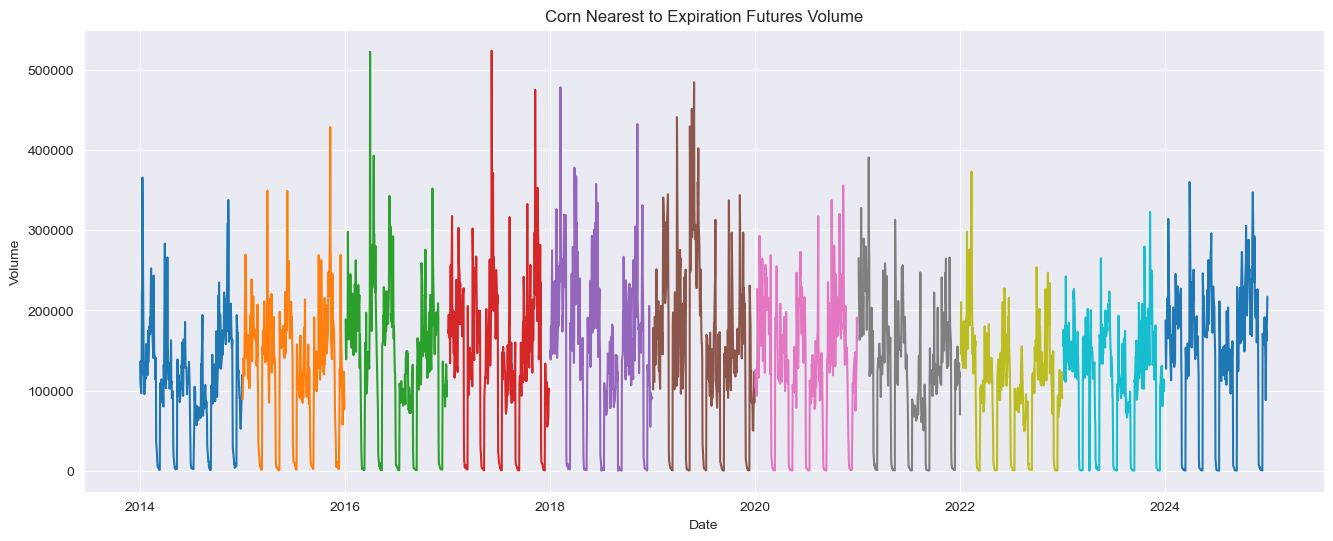

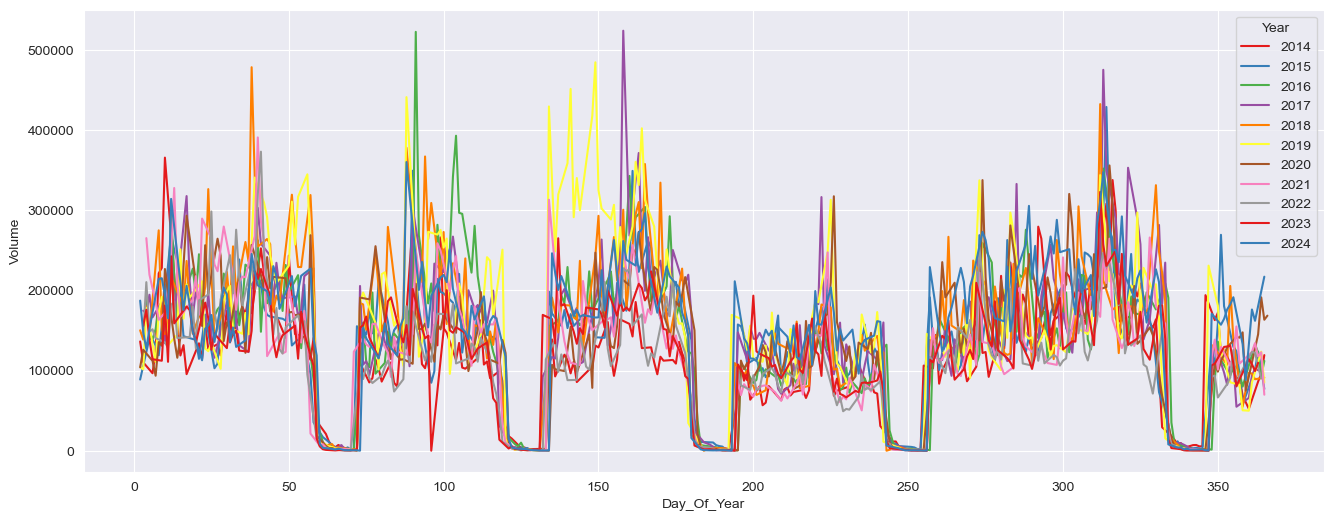

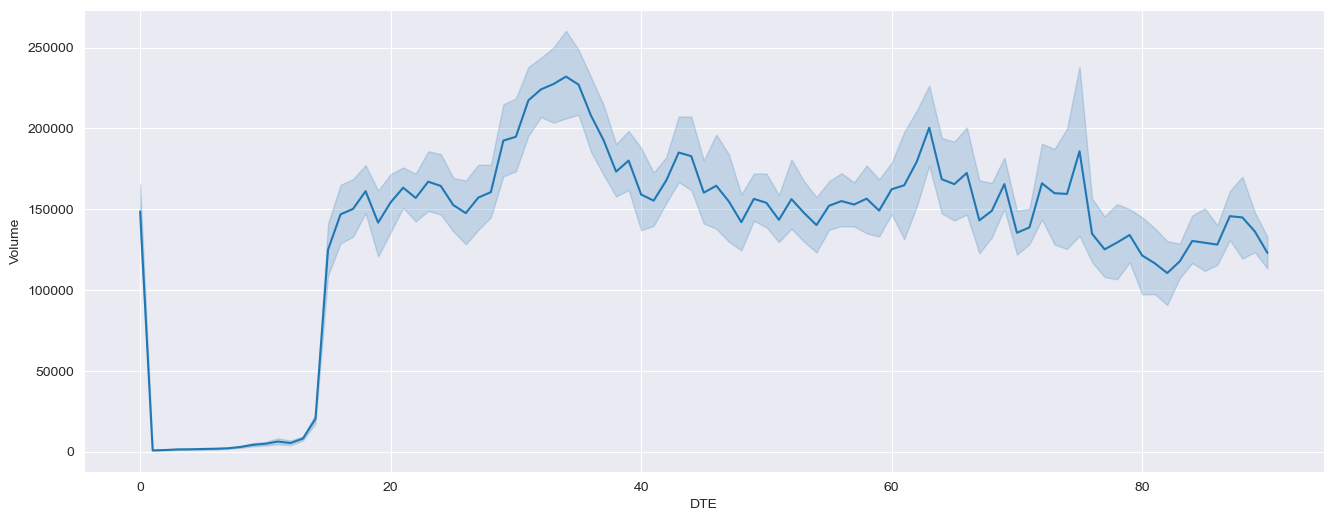

In [3]:
plt.figure(figsize = (16,6))
plt.title("Corn Nearest to Expiration Futures Volume")
for year in corn_data['Year'].unique():  # Loop through each unique year
    yearly_data = corn_data[corn_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Volume', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Volume', data = corn_data, hue ='Year', palette='Set1')
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'DTE', y = 'Volume', data = corn_data)
plt.show()

### Trading Volume Analysis
- **Seasonal patterns** are evident in trading volume, reflecting recurring market behavior.
- **Declining volume as expiry nears** – Many traders reduce activity in expiring contracts, shifting focus to
  later-dated futures instead of speculating on short-term price movements.
- **Pre-expiry volume surge** – As the expiry date approaches, traders must close positions to avoid physical delivery.
  This leads to a temporary spike in trading volume before the last trading day.
- **High trading volume in 2025** - The trading volume in 2025 Q1 is higher than the trading volume in previous years.


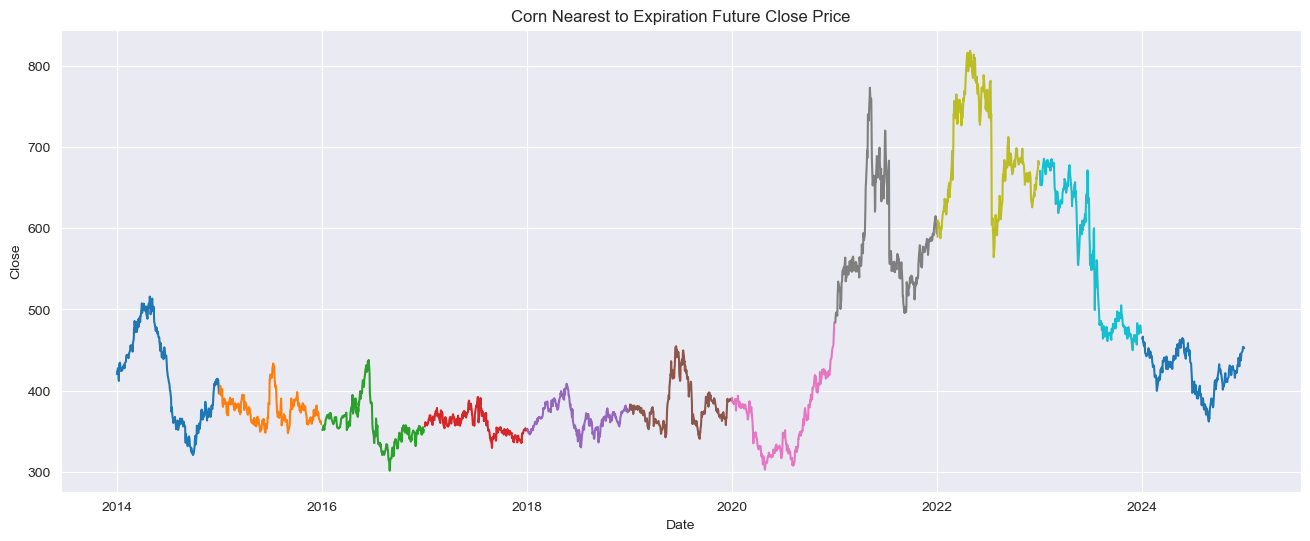

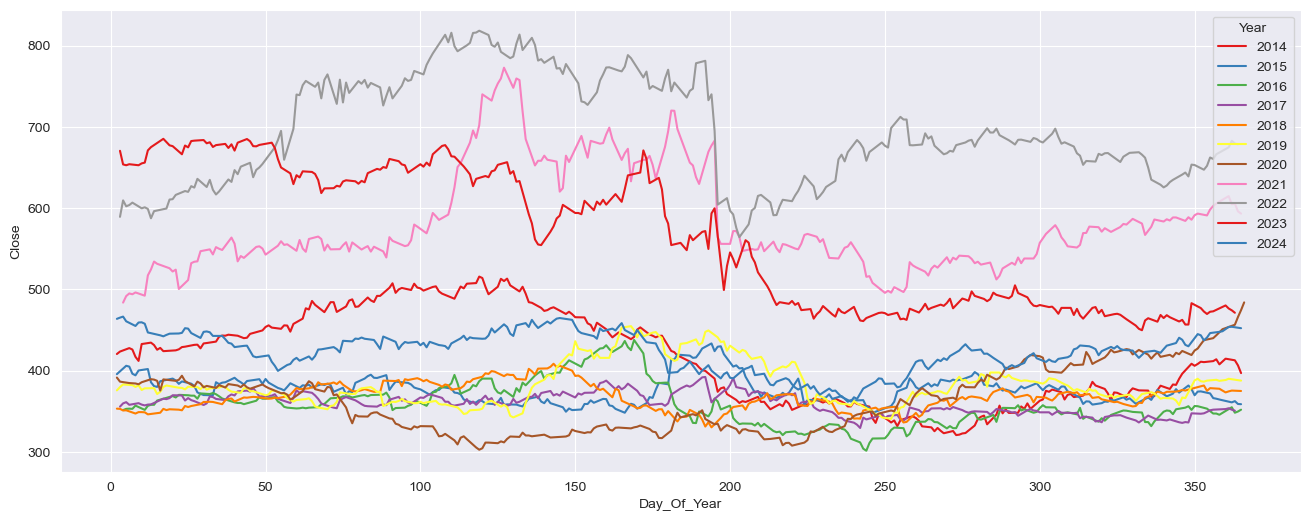

In [4]:
plt.figure(figsize = (16,6))
plt.title("Corn Nearest to Expiration Future Close Price")
for year in corn_data['Year'].unique():  # Loop through each unique year
    yearly_data = corn_data[corn_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Close', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Close', data = corn_data, hue ='Year', palette='Set1')
plt.show()

The fact that the log return looks g

count    2762.000000
mean        0.000026
std         0.016184
min        -0.190997
25%        -0.008552
50%         0.000000
75%         0.008789
max         0.077178
Name: Log_Return, dtype: float64


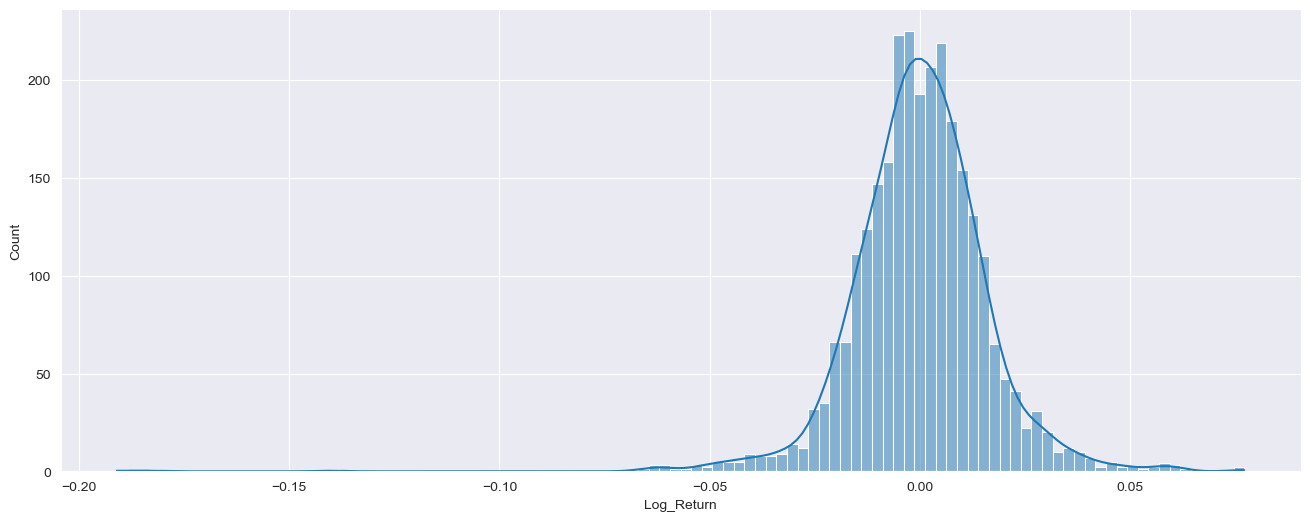

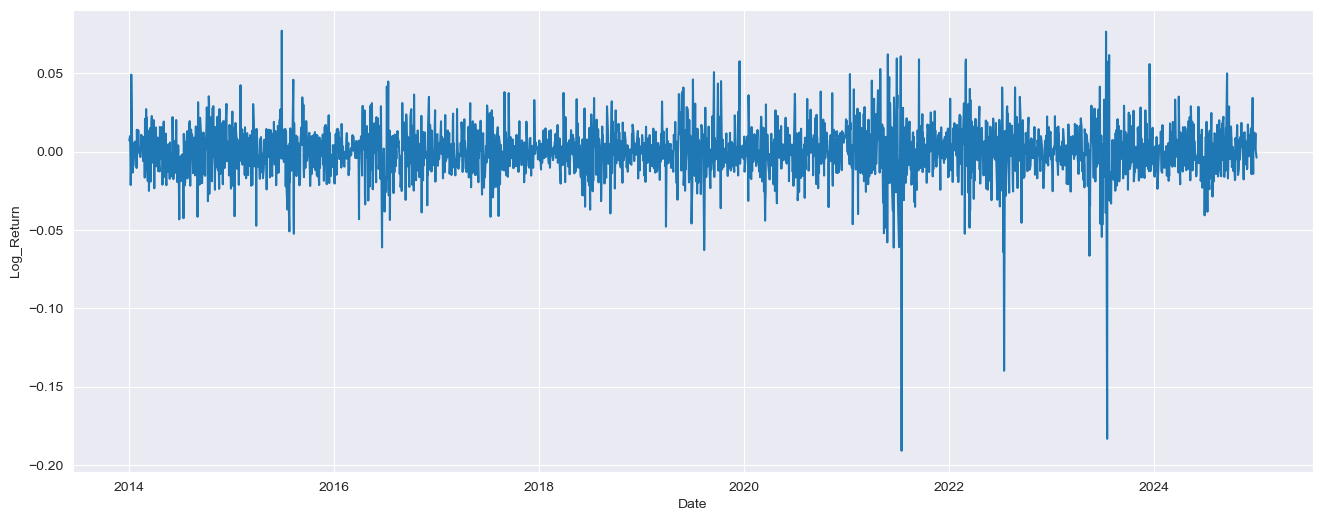

In [5]:
plt.figure(figsize = (16,6))
sns.histplot(corn_data['Log_Return'], kde = True)
print(corn_data['Log_Return'].describe())
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(corn_data['Log_Return'])
plt.show()

In [6]:
from src.data import DataLoader
dl = DataLoader()

production_raw = dl.get_production_data("CORN", 2014, national_level=True, raw=True)
production_national = production_raw[
    (production_raw.unit_desc == 'BU')
    & (production_raw.short_desc == 'CORN, GRAIN - PRODUCTION, MEASURED IN BU')
    & (production_raw.domain_desc == 'TOTAL')
    & (production_raw.reference_period_desc == 'YEAR')
][['state_name', 'Value', 'unit_desc', 'year', 'reference_period_desc', 'source_desc', 'short_desc']]

production_national['year'] = pd.to_numeric(production_national['year'])
production_national['Value'] = production_national['Value'].str.replace(',', '', regex=True)
production_national['Value'] = pd.to_numeric(production_national['Value'], errors='coerce')

stocks_national_raw = dl.get_stocks_data('CORN', 2014, True)
stocks_national_raw['end_month'] = stocks_national_raw['end_month'].astype(int)
stocks_national = stocks_national_raw[['year', 'end_month', 'CORN, GRAIN - STOCKS, MEASURED IN BU',
       'CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU',
       'CORN, ON FARM, GRAIN - STOCKS, MEASURED IN BU']]
stocks_national = stocks_national.rename(columns={
    'CORN, GRAIN - STOCKS, MEASURED IN BU': 'Total',
    'CORN, ON FARM, GRAIN - STOCKS, MEASURED IN BU': 'ON_FARM',
    'CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU': 'OFF_FARM',
})

C:\Users\johng23\AppData\Local\Temp\ipykernel_28316\99492220.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_years)


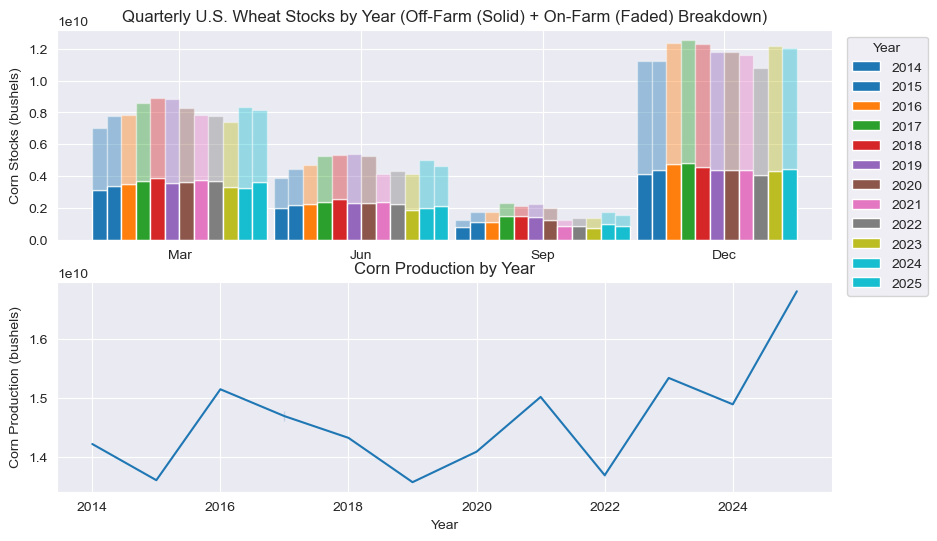

In [7]:

import matplotlib.cm as cm

month_map = {3: "Mar", 6: "Jun", 9: "Sep", 12: "Dec"}
stocks_national['month'] = stocks_national['end_month'].map(month_map)
months = ['Mar', 'Jun', 'Sep', 'Dec']
stocks_national['month'] = pd.Categorical(stocks_national['month'], categories=months, ordered=True)
stocks_national = stocks_national.sort_values(['month', 'year'])
years = sorted(stocks_national['year'].unique())
num_years = len(years)
bar_width = 0.08
positions = np.arange(len(months))

# Generate color map for each year
colors = cm.get_cmap('tab10', num_years)

fig, axes = plt.subplots(nrows=2, figsize=(10, 6))

ax=axes[0]
for i, year in enumerate(years):
    df_year = stocks_national[stocks_national['year'] == year]

    # Only include months that actually exist in this year's data
    valid_months = df_year['month'].tolist()
    month_indices = [months.index(m) for m in valid_months]

    offset = (i - num_years/2) * bar_width + bar_width/2
    x = np.array(month_indices) + offset

    # Fetch corresponding values in order
    on_farm_vals = df_year['ON_FARM'].values
    off_farm_vals = df_year['OFF_FARM'].values

    # Plot stacked bars
    ax.bar(x, off_farm_vals, width=bar_width, color=colors(i), label=f'{year}')
    ax.bar(x, on_farm_vals, width=bar_width, bottom=off_farm_vals, color=colors(i), alpha=0.4)

ax.set_xticks(positions)
ax.set_xticklabels(months)
# ax.set_xlabel("Month")
ax.set_ylabel("Corn Stocks (bushels)")
ax.set_title("Quarterly U.S. Wheat Stocks by Year (Off-Farm (Solid) + On-Farm (Faded) Breakdown)")
ax.legend(title="Year", bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))


sns.lineplot(x='year', y='Value', data=production_national, ax=axes[1])
axes[1].set_title("Corn Production by Year")
axes[1].set_ylabel("Corn Production (bushels)")
axes[1].set_xlabel("Year")

plt.show()

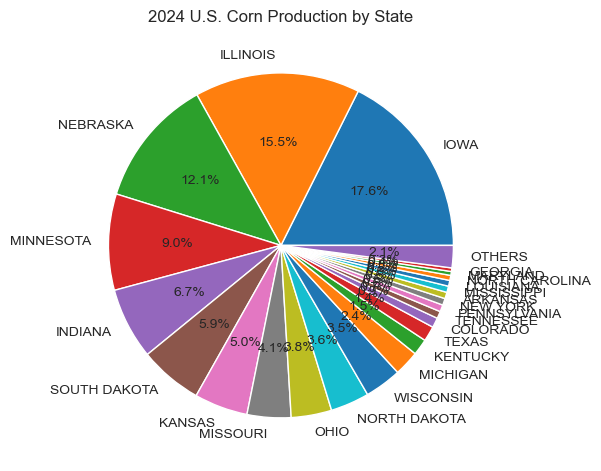

In [8]:
production_state_raw = dl.get_production_data("CORN", 2014, national_level=False, raw=True)

year = 2024
production_state = production_state_raw[
    (production_state_raw.unit_desc.isin(['BU', 'PCT BY TYPE'])) &
    (production_state_raw.reference_period_desc == 'YEAR') &
    (production_state_raw.year == year)
][['state_alpha', 'state_name', 'Value', 'unit_desc']]

production_state['Value'] = production_state['Value'].str.replace(',', '', regex=True)
production_state['Value'] = pd.to_numeric(production_state['Value'], errors='coerce')


fig, axes = plt.subplots(ncols=1, figsize=(10, 5.6))

# ploting the production for winter wheat by state
ax = axes

winter_production_state = production_state.sort_values('Value', ascending=False)
threshold = 48000000
major = winter_production_state[winter_production_state['Value'] >= threshold]
other = winter_production_state[winter_production_state['Value'] < threshold]
other_sum = other.Value.sum()

df_pie = pd.concat([
    major[['state_name', 'Value']],
    pd.DataFrame({'state_name': ['OTHERS'], 'Value': [other_sum]})
])

ax.set_title(f"{year} U.S. Corn Production by State")
ax.pie(df_pie.Value, labels=df_pie.state_name, autopct='%1.1f%%')

plt.show()

Most of the corn are produced in the corn belt of US, including Iowa, Illinois, Nebraska, Minneosta, and Indiana

In [9]:
condition_state_raw = pd.concat(dl.get_condition_data('CORN', 2014, exact_year = year, national_level=False, raw=True) for year in range(2014,2026))


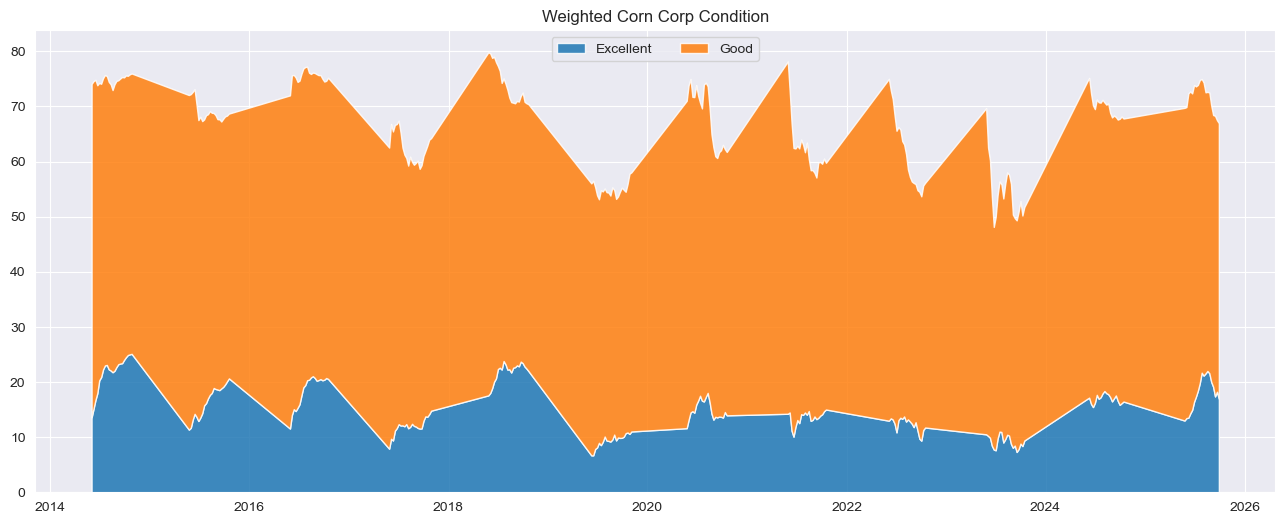

The correlation between the crop condition change and the next day price increment is 0.0539
The correlation between the crop condition change and the next 3 day price increment is -0.0145
The correlation between the crop condition change and the next 7 day price increment is 0.0247


In [10]:

Corn_states_of_interest = winter_production_state[:9][['state_name', 'Value']]
Corn_states_of_interest['weight'] = Corn_states_of_interest['Value'] / Corn_states_of_interest['Value'].sum()

condition_state_raw['year'] = pd.to_numeric(condition_state_raw['year'])
condition_state_raw['Value'] = pd.to_numeric(condition_state_raw['Value'], errors='coerce')
raw_data = condition_state_raw[
    (condition_state_raw.state_name.isin(Corn_states_of_interest['state_name']))
]
condition_state = raw_data.pivot(index=['week_ending', 'year', 'state_name', 'end_code'], columns='unit_desc', values='Value').reset_index()
condition_state.rename(columns={'end_code': 'week_number', 'week_ending': 'date'}, inplace=True)
condition_state.date = pd.to_datetime(condition_state.date)

# 1. Filter only Corn states
condition_Corn = condition_state[condition_state['state_name'].isin(Corn_states_of_interest['state_name'])]

# 2. Merge weights into condition data
condition_Corn = condition_Corn.merge(Corn_states_of_interest, on='state_name', how='left')

# 3. Compute weighted condition percentages
conditions = ['PCT EXCELLENT', 'PCT GOOD', 'PCT FAIR', 'PCT POOR', 'PCT VERY POOR']
for col in conditions:
    condition_Corn[col] = pd.to_numeric(condition_Corn[col], errors='coerce')
    condition_Corn[f'{col}_weighted'] = condition_Corn[col] * condition_Corn['weight']

# 4. Aggregate weekly by year
weekly_national = (
    condition_Corn
    .groupby(['date'])[[f'{c}_weighted' for c in conditions]]
    .sum()
    .reset_index()
)

weekly_national['sum'] = (
    weekly_national['PCT EXCELLENT_weighted'] +
    weekly_national['PCT GOOD_weighted'] +
    weekly_national['PCT FAIR_weighted'] +
    weekly_national['PCT POOR_weighted'] +
    weekly_national['PCT VERY POOR_weighted']
)

df = weekly_national[weekly_national['sum']>=80].copy()
for condition in conditions:
    df[f'{condition}_weighted'] = df[f'{condition}_weighted'] * 100 / df['sum']

plt.figure(figsize=(16,6))
plt.stackplot(
    df['date'],
    [df[f'{col}_weighted'] for col in ['PCT EXCELLENT', 'PCT GOOD']],
    labels=['Excellent', 'Good'],
    alpha=0.85
)
plt.title(f"Weighted Corn Corp Condition")
plt.legend(loc='upper center', ncol=2)
# plt.savefig('../imgs/wheat/condition.png')
plt.show()

df['Good'] = df['PCT EXCELLENT_weighted'] + df['PCT GOOD_weighted']
df.rename(columns={'date': 'Date'}, inplace=True)
merged = pd.merge(df, corn_data, how='outer', on='Date')
merged.sort_values('Date', inplace=True)
merged.ffill(inplace=True)
merged['next_day_increment'] = merged['Close'].shift(-1) - merged['Close']
merged['next_3day_increment'] = merged['Close'].shift(-3) - merged['Close']
merged['next_7day_increment'] = merged['Close'].shift(-7) - merged['Close']
data = merged[merged.Date.isin(df.Date)][['Date', 'Good', 'Close', 'next_day_increment', 'next_3day_increment', 'next_7day_increment']].dropna()
data['condition_increment'] = data['Good']-data['Good'].shift(1)
print(f"The correlation between the crop condition change and the next day price increment is {(data.condition_increment).corr(data.next_day_increment):.4f}")
print(f"The correlation between the crop condition change and the next 3 day price increment is {(data.condition_increment).corr(data.next_3day_increment):.4f}")
print(f"The correlation between the crop condition change and the next 7 day price increment is {(data.condition_increment).corr(data.next_7day_increment):.4f}")
